In [1]:
import matplotlib.pyplot as plt
import numpy as np
import cv2 as cv
from scipy.signal import argrelextrema


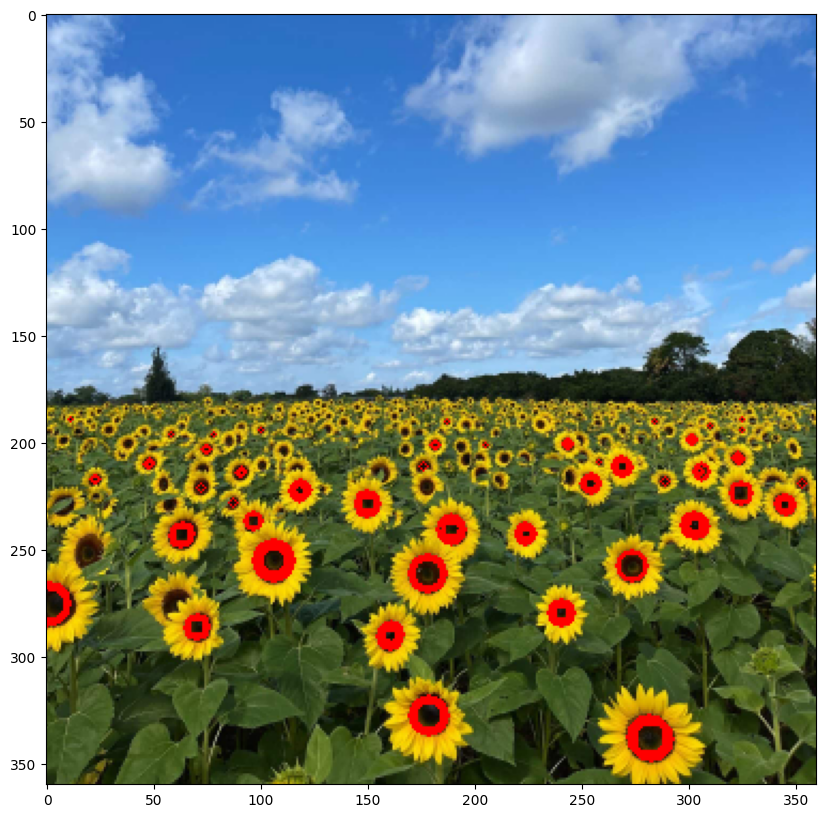

In [100]:
image = cv.imread("the_berry_farms_sunflower_field.jpeg",cv.IMREAD_REDUCED_COLOR_4)
image = cv.cvtColor(image, cv.COLOR_BGR2RGB)
image_gray = cv.cvtColor(image, cv.COLOR_RGB2GRAY)
h,w = image_gray.shape

threshold = 80

sigma_values = np.arange(1, 25, 1)
scale_space = np.zeros((h, w, len(sigma_values)))

for i, sigma in enumerate(sigma_values):
    
    log_hw = 3 * sigma
    X, Y = np.meshgrid(np.arange(-log_hw, log_hw + 1), np.arange(-log_hw, log_hw + 1))
    X = X.astype(np.float32)
    Y = Y.astype(np.float32)
    
    log = 1 / (2 * np.pi * sigma**2) * (X**2 / (sigma**2) + Y**2 / (sigma**2) - 2) * np.exp(-(X**2 + Y**2) / (2 * sigma**2))
    f_log = cv.filter2D(image_gray, -1, log)
    scale_space[:, :, i] = np.absolute(f_log)

  
for i in range(h) :
    for j in range(w) :
        maximum = np.max(scale_space[i,j,:])
        if threshold < maximum :
            ind = np.argmax(scale_space[i,j,:])
            sigma = sigma_values[ind]
            radius = int((2**0.5)*sigma)
            cv.circle(image, (j,i), radius, [255,0,0],1)

plt.figure(figsize=(10,10))
plt.imshow(image)

*Q2*

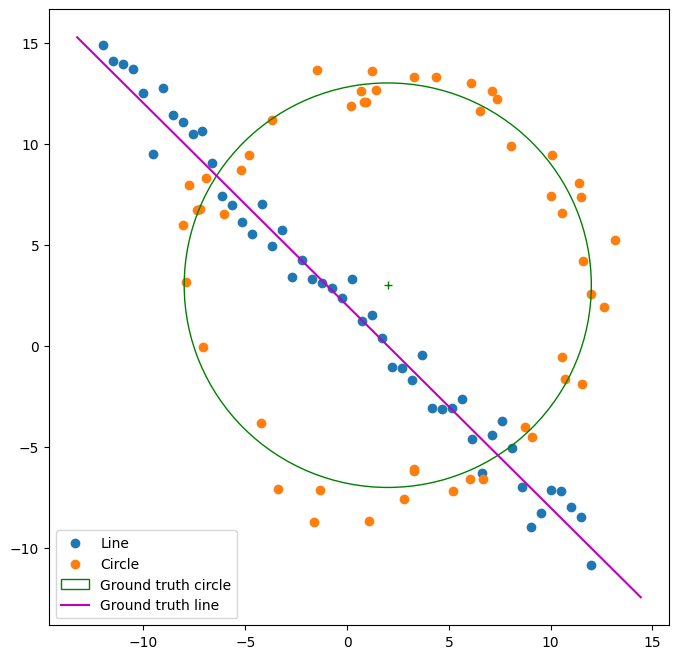

In [13]:
from scipy.optimize import minimize
from scipy import linalg
import matplotlib.pyplot as plt
import numpy as np
import math


# np.random.seed(0)

N = 100
half_n = N // 2
r = 10
x0_gt, y0_gt = 2, 3  # Center
s = r / 16
t = np.random.uniform(0, 2 * np.pi, half_n)
n = s * np.random.randn(half_n)
x, y = x0_gt + (r + n) * np.cos(t), y0_gt + (r + n) * np.sin(t)
X_circ = np.hstack((x.reshape(half_n, 1), y.reshape(half_n, 1)))

s = 1.
m, b = -1, 2
x = np.linspace(-12, 12, half_n)
y = m * x + b + s * np.random.randn(half_n)
X_line = np.hstack((x.reshape(half_n, 1), y.reshape(half_n, 1)))

X = np.vstack((X_circ, X_line))  # All points

fig, ax = plt.subplots(1, 1, figsize=(8, 8))
ax.scatter(X_line[:, 0], X_line[:, 1], label='Line')
ax.scatter(X_circ[:, 0], X_circ[:, 1], label='Circle')

circle_gt = plt.Circle((x0_gt, y0_gt), r, color='g', fill=False, label='Ground truth circle')
ax.add_patch(circle_gt)
ax.plot(x0_gt, y0_gt, '+', color='g')

x_min, x_max = ax.get_xlim()
x_ = np.array([x_min, x_max])
y_ = m * x_ + b
plt.plot(x_, y_, color='m', label='Ground truth line')

plt.legend()

Optimization terminated successfully    (Exit mode 0)
            Current function value: 3.5930072949981276e-12
            Iterations: 9
            Function evaluations: 48
            Gradient evaluations: 9
Optimization terminated successfully    (Exit mode 0)
            Current function value: 7.362289394625259e-09
            Iterations: 9
            Function evaluations: 44
            Gradient evaluations: 9
Optimization terminated successfully    (Exit mode 0)
            Current function value: 3.8889333940138966e-11
            Iterations: 8
            Function evaluations: 36
            Gradient evaluations: 8
Optimization terminated successfully    (Exit mode 0)
            Current function value: 3.975416498528152e-09
            Iterations: 9
            Function evaluations: 41
            Gradient evaluations: 9
Optimization terminated successfully    (Exit mode 0)
            Current function value: 8.250042757246166e-09
            Iterations: 9
            Func

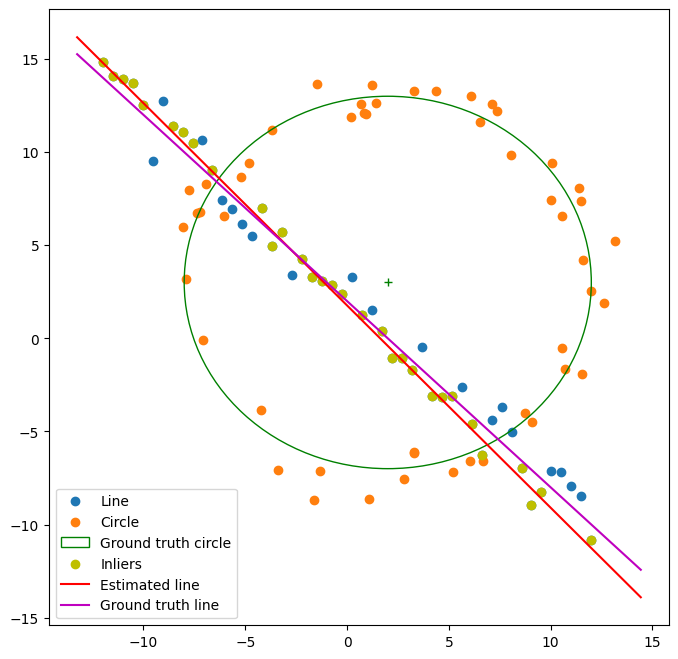

In [45]:
# total least square error for a line
def tls(abd, indexes):
    a,b,d = abd[0], abd[1], abd[2]
    return np.sum(np.square(a*X[indexes,0] + b*X[indexes,1] - d))

# constrain function
def con_fun(abd) :
    return abd[0]**2 + abd[1]**2 - 1  # a,b,d values will be found considering this constrain function 

constrain = ({'type': 'eq', 'fun': con_fun})


# this function will find the inliers for line when a,b,d are given
def consensus_line(abd, x, th) :
    return (np.absolute(abd[0]*x[:,0] + abd[1]*x[:,1] - abd[2])) < th 
        

def ransac(X, iteration, th, th_inliers) :
    
    n = X.shape[0]         # number of data points
    best_error = np.inf    # initial guess for error
    best_inliers = []      # inliers which is closer to the best predicted line
    
    for i in range(iteration) :

        indexes = np.random.choice(n, 2, replace=False)   # two random points 
        abd = [1,0,0]           # initial guess for line parameters

        # minimize the tls function changing a,b,d parameters 
        result = minimize(fun=tls, args=indexes, x0 = abd, tol=1e-6,constraints=constrain, options={'disp': True})

        # inliers which is close to the predicted line
        inliers = consensus_line(result.x, X,th)

        # number of inliers
        n_inliers = np.sum(inliers)


        if n_inliers > th_inliers :
            abd = result.x       # so far the best a,b,d values found
            
            result = minimize(fun=tls, args=indexes, x0= abd, tol=1e-6,constraints=constrain, options={'disp': True})

            if result.fun < best_error :
                best_error = result.fun
                best_a, best_b, best_d = result.x
                best_inliers = inliers    # inlierss of the best fitting line

    return best_a, best_b, best_d, best_indexes, best_inliers     

best_a, best_b, best_d, best_indexes, best_inliers = ransac(X, 500, 0.6,0.3*X.shape[0]) 


fig, ax = plt.subplots(1, 1, figsize=(8, 8))
ax.scatter(X_line[:, 0], X_line[:, 1], label='Line')
ax.scatter(X_circ[:, 0], X_circ[:, 1], label='Circle')
circle_gt = plt.Circle((x0_gt, y0_gt), r, color='g', fill=False, label='Ground truth circle')
ax.add_patch(circle_gt)
ax.plot(x0_gt, y0_gt, '+', color='g')
ax.scatter(X[best_inliers,0],X[best_inliers,1], color='y', label='Inliers')

x_min, x_max = ax.get_xlim()
x_ = np.array([x_min, x_max])
y_ = m * x_ + b
y_pred = (-best_a/best_b)*x_ + best_d/best_b

plt.plot(x_, y_pred, color='r', label='Estimated line')
plt.plot(x_, y_, color='m', label='Ground truth line')
plt.legend()
plt.show()


Optimization terminated successfully    (Exit mode 0)
            Current function value: 4.039031476324247
            Iterations: 69
            Function evaluations: 436
            Gradient evaluations: 69
Iteration limit reached    (Exit mode 9)
            Current function value: 1.6501900542244208
            Iterations: 100
            Function evaluations: 551
            Gradient evaluations: 100
Iteration limit reached    (Exit mode 9)
            Current function value: 1.8736615404295662
            Iterations: 100
            Function evaluations: 569
            Gradient evaluations: 100
Iteration limit reached    (Exit mode 9)
            Current function value: 0.18815713003761658
            Iterations: 100
            Function evaluations: 489
            Gradient evaluations: 100
Optimization terminated successfully    (Exit mode 0)
            Current function value: 5.9778151451194415
            Iterations: 78
            Function evaluations: 498
            Gra

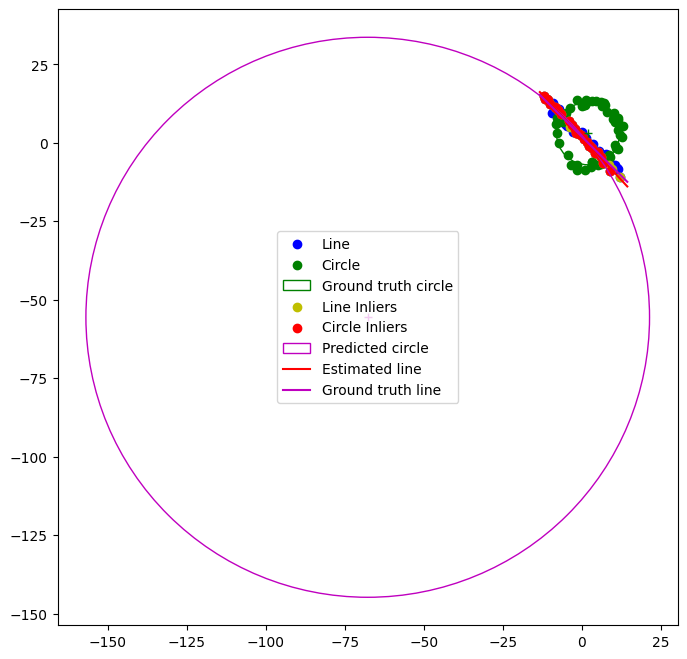

In [53]:
if np.sum(best_inliers) != 0 :
    X_circle = X[best_inliers, :]
else :
    X_circle = X

def consensus_circle(data, model, th) :
    c_x, c_y, r = model
    dis = np.sqrt((data[:,0] - c_x)**2 + (data[:,1] - c_y)**2)
    return np.abs(dis - r) < th

def tls_circle(xyr, X, indexes) :
    c_x, c_y, r = xyr[0], xyr[1], xyr[2]
    error = np.sqrt((X[indexes,0] - c_x)**2 + (X[indexes,1] - c_y)**2)
    return np.sum(np.abs(error - r))

th = 1
constrain = {'type': 'ineq', 'fun': lambda x: x[2] - th}

def ransac_circle(X, iteration, th, th_inliers):
    n = X.shape[0]
    best_error_circle = np.inf
    best_inliers_circle = []

    for i in range(iteration) :
        indexes = np.random.choice(n, 3, replace=False)
        xyr = [1,1,1]
        result = minimize(fun=tls_circle, args=(X,indexes), x0=xyr, tol=1e-6,constraints=constrain,options={'disp': True})

        inliers = consensus_circle(X, result.x, th)
        n_inliers = np.sum(inliers)

        if n_inliers > th_inliers :
            xyr = result.x
            result = minimize(fun=tls_circle, args=(X,indexes), x0=xyr, tol=1e-6,constraints=constrain,options={'disp': True})

            if result.fun < best_error_circle :
                best_error_circle = result.fun
                best_x, best_y, best_r = result.x
                best_inliers_circle = inliers    # inlierss of the best fitting circle

    return best_x, best_y, best_r, best_inliers_circle

best_x, best_y, best_r, best_inliers_circle = ransac_circle(X_circle,500,th ,0.85*X_circle.shape[0])

fig, ax = plt.subplots(1, 1, figsize=(8, 8))

ax.scatter(X_line[:, 0], X_line[:, 1], color='b', label='Line')
ax.scatter(X_circ[:, 0], X_circ[:, 1], color='g', label='Circle')

circle_gt = plt.Circle((x0_gt, y0_gt), r, color='g', fill=False, label='Ground truth circle')
ax.add_patch(circle_gt)
ax.plot(x0_gt, y0_gt, '+', color='g')


ax.scatter(X[best_inliers, 0], X[best_inliers, 1], color='y', label='Line Inliers')
ax.scatter(X_circle[best_inliers_circle, 0], X_circle[best_inliers_circle, 1], color='r', label='Circle Inliers')
circle_pred = plt.Circle((best_x, best_y), best_r, color='m', fill=False, label='Predicted circle')

ax.add_patch(circle_pred)
ax.plot(best_x, best_y, '+', color='m')

plt.plot(x_, y_pred, color='r', label='Estimated line')
plt.plot(x_, y_, color='m', label='Ground truth line')

plt.legend()
plt.show()


In [56]:
image3_bg = cv.imread("college.jpg", cv.IMREAD_COLOR)
image3_flag = cv.imread("flag.png", cv.IMREAD_COLOR)
hb, wb, __ = image3_bg.shape
h, w, _ = image3_flag.shape

corners_bg = []
corners_flag = []

def mouse_callback(event, x,y, flags, param) :
    global corners_bg
    key = cv.waitKey(1) & 0xFF

    if (event == cv.EVENT_LBUTTONDOWN) :
        corners_bg.append((x,y))       # corner selecting pattern : left-upper -> right-upper -> right-bottom -> left-bottom
        cv.circle(image3_bg, (x,y), 3, (255,0,255),2)
        cv.imshow("Image", image3_bg)

    if (len(corners_bg) == 4) :
        cv.destroyAllWindows()

    
cv.namedWindow("Image")
cv.imshow("Image", image3_bg)
cv.setMouseCallback("Image", mouse_callback)
cv.waitKey(0)


corners_flag = [(0,0), (w,0), (w,h), (0,h)]

print("corners of background : ", corners_bg)
print("corners of flag : ", corners_flag)



corners of background :  [(529, 221), (864, 165), (866, 388), (530, 412)]
corners of flag :  [(0, 0), (1546, 0), (1546, 775), (0, 775)]


(<matplotlib.image.AxesImage at 0x250fc159390>, Text(0.5, 1.0, 'Result'))

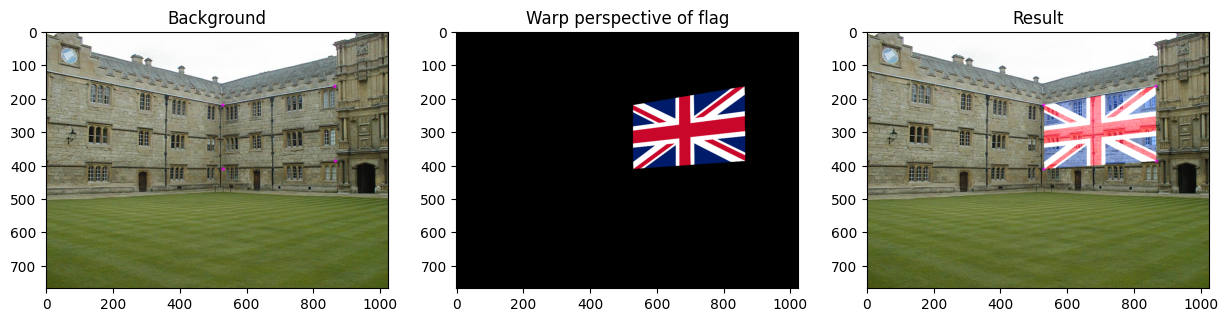

In [57]:
corners_bg = np.array(corners_bg, dtype=np.float32)
corners_flag = np.array(corners_flag, dtype=np.float32)
homography,_  = cv.findHomography(corners_flag, corners_bg, method=cv.RANSAC)

warp = cv.warpPerspective(image3_flag, homography, (wb,hb))
warp = cv.cvtColor(warp, cv.COLOR_BGR2RGB)

alpha = 0.1
cvt_image3_bg = cv.cvtColor(image3_bg, cv.COLOR_BGR2RGB)
blended_image = cv.addWeighted(cvt_image3_bg, 1, warp, 1-alpha, 0)

fig, ax = plt.subplots(1,3, figsize = (15,8))
ax[0].imshow(cvt_image3_bg), ax[0].set_title("Background")
ax[1].imshow(warp), ax[1].set_title("Warp perspective of flag")
ax[2].imshow(blended_image), ax[2].set_title("Result")

*_Q4_*

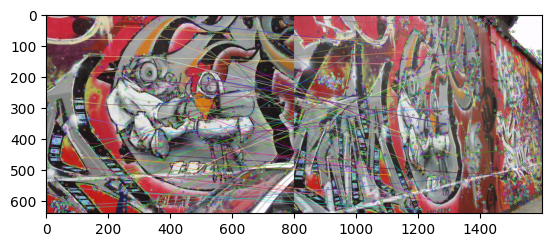

In [36]:
image4_1 = cv.imread("graf/img1.jpg")
image4_2 = cv.imread("graf/img5.jpg")

gray_1 = cv.cvtColor(image4_1, cv.COLOR_BGR2GRAY)
gray_2 = cv.cvtColor(image4_2, cv.COLOR_BGR2GRAY)

sift = cv.SIFT_create()

keypoints1, des1 = sift.detectAndCompute(gray_1, None)
keypoints2, des2 = sift.detectAndCompute(gray_2, None)

bf = cv.BFMatcher()
matches = bf.knnMatch(des1, des2, k=2)

th_matches = []

for m,n in matches :
    if (m.distance < 0.75*n.distance) :
        th_matches.append(m)

matched = cv.drawMatches(image4_1, keypoints1, image4_2, keypoints2, th_matches,None)

matched = cv.cvtColor(matched, cv.COLOR_BGR2RGB)

plt.imshow(matched)

